# Distributed Compressed Sensing
## Parameter Definition and Centralized Optimization

The centralized reference problem is:

$$
\min_{x \in \mathbb{R}^d} \quad \frac{1}{16}\sum_{i = 1}^{16}\left\|C_i \Psi x - y_i\right\|_2^2 + \lambda \|x\|_1 .
$$

Here, $C_i$ is the local measurement (sampling) operator at worker $i$ (implemented as randomly selected rows of the identity matrix), $\Psi$ is the discrete cosine transform (DCT) basis, and $y_i$ is the corresponding local observation vector.
We denote the optimal centralized solution by $x^*$, which serves as the reference solution for the distributed experiments.

The communication network is organized as a $4 \times 4$ grid, where each node communicates only with its immediate neighbors.
The gossip (mixing) matrix is defined as
$$
W = I - 0.1 L,
$$
where $L$ is the graph Laplacian of the grid.
This matrix is used to perform local information averaging among neighboring nodes in each iteration.

In [1]:
import numpy as np
import numpy.typing as npt

if __name__ == "__main__":
    import cvxpy as cp
    from scipy.fftpack import fft, dct

    # Sensors topology and mixing matrix
    import networkx as nx
    from topolink import Graph, bootstrap

    n_grid = 4
    grid = nx.grid_2d_graph(n_grid, n_grid)
    L: npt.NDArray[np.float64] = np.asarray(nx.laplacian_matrix(grid))
    W = np.eye(16) - L * 0.1

    graph = Graph.from_mixing_matrix(W, transport="ipc")
    n_sens = graph.number_of_nodes
    sens_names = [f"{i + 1}" for i in range(n_sens)]

    # Original signal
    n = 4096
    t = np.linspace(0, 1, n)
    x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)
    xt = fft(x)
    psd = (np.abs(xt) ** 2) / n

    # Signal sampling
    np.random.seed(3)
    p_total = 128
    p_sens = p_total // n_sens
    perm = {i: np.round(np.random.rand(p_sens) * n).astype(int) for i in sens_names}
    y = {i: x[perm[i]] for i in sens_names}

    # Sensing matrix and regularization parameter
    Psi = dct(np.eye(n), norm="ortho")
    Theta = {i: Psi[perm[i], :] for i in sens_names}
    lam = 0.01

    # Centralized optimization
    s_hat = cp.Variable(n)
    cost = sum(
        [cp.norm2(Theta[i] @ s_hat - y[i]) ** 2 for i in sens_names]
    ) / n_sens + lam * cp.norm1(s_hat)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve(solver=cp.ECOS)

    s_hat_star: npt.NDArray[np.float64] = np.asarray(s_hat.value)

    print(f"Centralized optimization result: {s_hat_star}")

Centralized optimization result: [-3.11062644e-12  4.41373983e-12 -1.98379001e-12 ... -2.45602406e-12
 -3.54234338e-13 -1.71501921e-12]


/home/rui/code/discoopt/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### Global Matplotlib Plotting Parameters and Sensor Color Scheme

In [2]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    plt.rcParams["text.usetex"] = True  # 使用外部 LaTeX 编译器
    plt.rcParams["font.family"] = "serif"  # 设置字体为 LaTeX 的默认 serif 字体

    plt.rcParams.update(
        {
            "font.size": 14,  # 全局字体大小
            "axes.titlesize": 16,  # 坐标轴标题字体大小
            "axes.labelsize": 16,  # 坐标轴标签字体大小
            "xtick.labelsize": 16,  # x轴刻度标签字体大小
            "ytick.labelsize": 16,  # y轴刻度标签字体大小
            "legend.fontsize": 13,  # 图例字体大小
        }
    )

    sens_color = {
        "1": "#1f77b4",  # 蓝色
        "2": "#ff7f0e",  # 橙色
        "3": "#2ca02c",  # 绿色
        "4": "#d62728",  # 红色
        "5": "#9467bd",  # 紫色
        "6": "#8c564b",  # 棕色
        "7": "#e377c2",  # 粉色
        "8": "#7f7f7f",  # 灰色
        "9": "#bcbd22",  # 黄绿色
        "10": "#17becf",  # 青色
        "11": "#393b79",  # 深蓝
        "12": "#52519e",  # 蓝紫色
        "13": "#6b4196",  # 紫罗兰
        "14": "#85397e",  # 深紫红
        "15": "#7f4172",  # 梅红色
        "16": "#7f4e52",  # 深红棕
    }

### Original signal with multi-sensor sampling

Each sensor samples the same underlying signal at **8 Hz**, but uses **different randomly selected time points**.  
The colored crosses indicate the sampling locations of different sensors.

This setting corresponds to multiple sensors observing the same signal through different random sampling operators $C_i$.

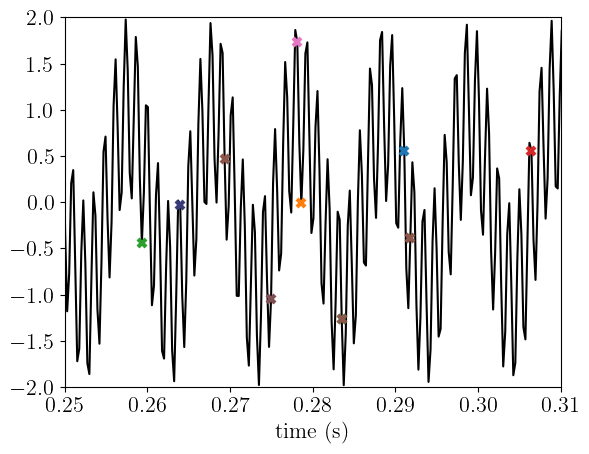

In [3]:
if __name__ == "__main__":
    fig, ax = plt.subplots()
    ax.set_xlim((0.25, 0.31))
    ax.set_ylim((-2, 2))

    ax.plot(t, x, "k")
    for i in sens_names:
        ax.plot(t[perm[i]], y[i], "x", color=sens_color[i], markeredgewidth=3)

    ax.set_xlabel("time (s)")

### Original signal PSD

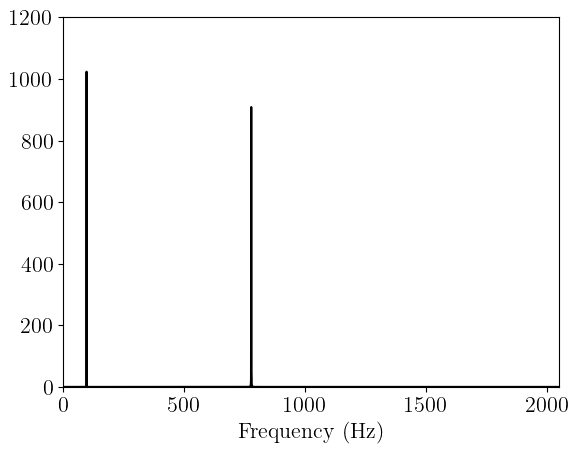

In [4]:
if __name__ == "__main__":
    fig, ax = plt.subplots()
    ax.set_xlim((0, n // 2))
    ax.set_ylim((0, 1200))
    ax.set_xlabel("Frequency (Hz)")

    ax.plot(psd[: n // 2], "k")

## Benchmarking Distributed Optimization Algorithms

In this section, we compare the distributed optimization algorithms `RAugDGM`, `RGT`, `WE`, and `RGD` on the ridge regression problem.
Each method is run with its own recommended step size.

Performance is evaluated using the mean squared error (MSE) with respect to the centralized reference solution:

$$
\frac{1}{16n} \sum_{i=1}^{16} \| \hat{s}_i - \hat{s}^* \|_2^2 ,
$$

where $\hat{s}_i \in \mathbb{R}^n$ denotes the local estimate at node $i$, and $\hat{s}^* \in \mathbb{R}^n$ is the centralized optimal solution.
The MSE is reported across iterations.

In [5]:
from multiprocessing import Pool


def lasso(
    node_id: str,
    theta_i: npt.NDArray[np.float64],
    y_i: npt.NDArray[np.float64],
    dim_i: int,
    lam_i: float,
    gamma: float,
    algorithm: str,
    optimal_solution: npt.NDArray[np.float64],
) -> tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    from numpy import zeros

    max_iter = 7000
    s_hat_i = zeros((max_iter, dim_i), dtype=np.float64)
    # Define the loss function
    from numpy import mean
    from jax import Array
    from jax.numpy.linalg import norm

    def f(var: npt.NDArray[np.float64]) -> Array:
        return norm(theta_i @ var - y_i) ** 2

    # Define the regularizer
    from dco import L1

    g = L1(lam_i)

    # Define the node handle
    from topolink import NodeHandle
    from topolink.transform import Quantize

    nh = NodeHandle(node_id, transform=Quantize("int16"), transport="ipc")

    # Define the optimizer and run iterations
    from dco import get_optimizer

    optimizer = get_optimizer(algorithm)(f, nh, gamma, g)

    optimizer.init(s_hat_i[0])

    for k in range(max_iter - 1):
        s_hat_i[k + 1] = optimizer.step(s_hat_i[k])

    final_iteration = s_hat_i[-1]
    mse_evolution = mean((s_hat_i - optimal_solution) ** 2, axis=1)

    return final_iteration, mse_evolution


if __name__ == "__main__":
    step_sizes = {
        "RAugDGM": 1.358,
        "AtcWE": 1.123,
        "WE": 0.893,
        "RGT": 0.656,
        "AugDGM": 1.358,
        "EXTRA": 0.893,
        "NIDS": 1.083,
        "DIGing": 0.656,
    }
    recovered_signal: npt.NDArray[np.float64]
    mse_by_algorithm: dict[str, npt.NDArray[np.float64]] = {}

    with Pool(processes=n_sens) as pool:
        for alg, gam in step_sizes.items():
            bootstrap(graph)

            tasks = [
                pool.apply_async(
                    lasso, args=(i, Theta[i], y[i], n, lam, gam, alg, s_hat_star)
                )
                for i in sens_names
            ]

            results = [task.get() for task in tasks]

            if alg == "RAugDGM":
                recovered_signal = results[3][0]
            mse_by_algorithm[alg] = np.mean([res[1] for res in results], axis=0)

            print(f"Algorithm: {alg}, Step size: {gam}, Finished!")

Algorithm: RAugDGM, Step size: 1.358, Finished!
Algorithm: AtcWE, Step size: 1.123, Finished!
Algorithm: WE, Step size: 0.893, Finished!
Algorithm: RGT, Step size: 0.656, Finished!
Algorithm: AugDGM, Step size: 1.358, Finished!
Algorithm: EXTRA, Step size: 0.893, Finished!
Algorithm: NIDS, Step size: 1.083, Finished!
Algorithm: DIGing, Step size: 0.656, Finished!


## Plot results

### MSE for robust algorithms `RAugDGM`, `RGT`, `WE`, and `RGT`

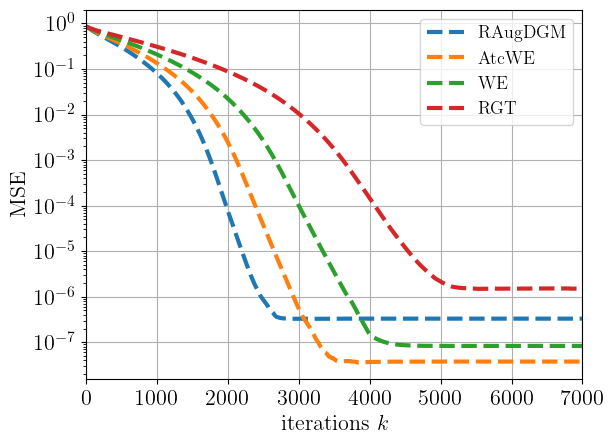

In [6]:
if __name__ == "__main__":
    fig, ax = plt.subplots()
    ax.set_xlim((0, 7000))
    ax.set_xlabel("iterations $k$")
    ax.set_ylabel("MSE")

    line_options = {"linewidth": 3, "linestyle": "--"}

    robust_algorithms = ["RAugDGM", "AtcWE", "WE", "RGT"]
    for alg in robust_algorithms:
        mse = mse_by_algorithm[alg]
        ax.semilogy(mse, label=alg, **line_options)

    ax.legend(loc="upper right")
    ax.grid(True, which="major", linestyle="-", linewidth=0.8)

### MSE for `RAugDGM` and non-robust algorithms `EXTRA`, `AugDGM`, `NIDS`, and `DIGing`

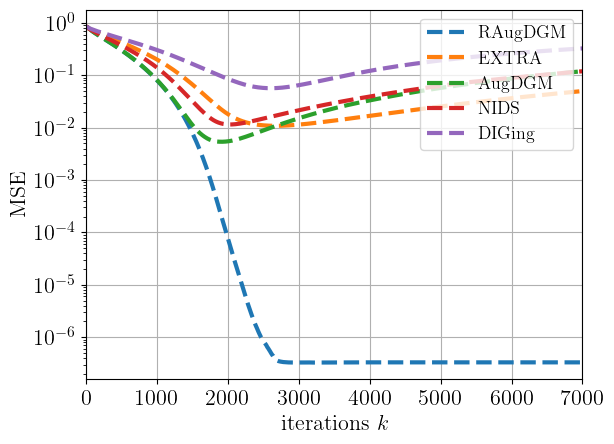

In [ ]:
if __name__ == "__main__":
    fig, ax = plt.subplots()
    ax.set_xlim((0, 7000))
    ax.set_xlabel("iterations $k$")
    ax.set_ylabel("MSE")

    line_options = {"linewidth": 3, "linestyle": "--"}

    nonrobust_algorithms = ["RAugDGM", "EXTRA", "AugDGM", "NIDS", "DIGing"]
    for alg in nonrobust_algorithms:
        mse = mse_by_algorithm[alg]
        ax.semilogy(mse, label=alg, **line_options)

    ax.legend(loc="upper right")
    ax.grid(True, which="major", linestyle="-", linewidth=0.8)

### Reconstructed signal at a representative node (all nodes exhibit similar performance)

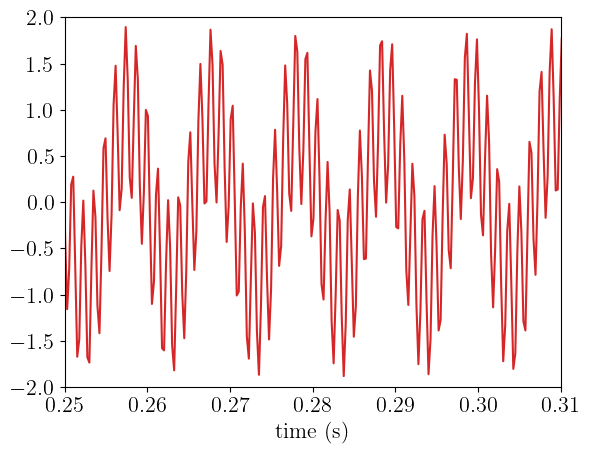

In [8]:
if __name__ == "__main__":
    from scipy.fftpack import idct

    fig, ax = plt.subplots()

    x_recon = idct(recovered_signal, norm="ortho").reshape(-1)

    ax.plot(t, x_recon, color=sens_color["4"])

    ax.set_xlim((0.25, 0.31))
    ax.set_ylim((-2, 2))
    ax.set_xlabel("time (s)")

### Reconstructed PSD

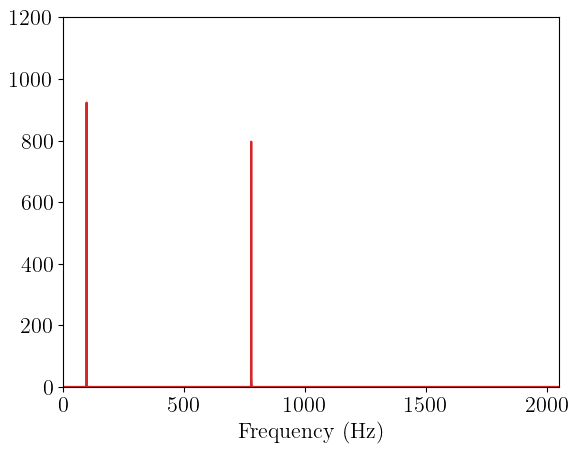

In [9]:
if __name__ == "__main__":
    fig, ax = plt.subplots()

    x_recon_t = fft(x_recon)
    psd_recon = (np.abs(x_recon_t) ** 2) / n

    ax.set_xlim((0, n // 2))
    ax.set_ylim((0, 1200))
    ax.set_xlabel("Frequency (Hz)")
    ax.plot(psd_recon[: n // 2], color=sens_color["4"])